In [1]:
import onnx
import torch
import numpy as np
import pandas as pd  
import copy
import pprint
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

from torch import nn

import sys
sys.path.append('/Users/khoanguyen-cp/gmu/network_properties')

from models.test_models import ProphecyPaperNetwork, TestModel
from models.acasxu_1_1 import Acasxu1_1
from models.utils import attach_relu_activation_hook, attach_layer_output_hook, get_layers_info
from models.utils import turn_bool_activation_to_int, turn_bool_activation_to_str

from algorithms.decision_procedure import MarabouCoreDP
from algorithms.under_approximation_box import UnderApproximationBox

Instructions for updating:
non-resource variables are not supported in the long term


## 1. Prepare model and data

In [2]:
model = Acasxu1_1()
model.load_state_dict(torch.load('../models/acasxu_1_1.pt'))

<All keys matched successfully>

In [3]:
def read_inputs_from_file(inputFile):
  num = 0 
  with open(inputFile) as f:
    lines = f.readlines()
    print(len(lines), "examples")
    features = np.empty([len(lines),5],dtype=float)
    labels = np.zeros(len(lines),dtype=int)

    for l in range(len(lines)):
      k = [float(stringIn) for stringIn in lines[l].split(',')] 
      if len(k) > 5:
        lab = int(k[5])
        labels[l+num] = lab
      count = 0
      for i in range(0,5):
        features[l+num][i] = k[i]
  return features, labels

def create_df(inputs, predicted_labels, true_labels):
  data = []
  for index, input_data in enumerate(inputs):
    data_point = { 
      "input": input_data, 
      "true_label": true_labels[index], 
      "predicted_label": predicted_labels[index].item(),
    }
    data.append(data_point)
  return pd.DataFrame(data)

In [4]:
acas_train, acas_train_labels = read_inputs_from_file('../datasets/clusterinACAS_0_shrt.csv')
outputs = model(torch.tensor(acas_train, dtype=torch.float32))
predicted_labels = torch.argmin(outputs, dim=1)
df = create_df(acas_train, predicted_labels, acas_train_labels)
df.head(10)

384221 examples


,input,true_label,predicted_label
0,"[-0.320142, -0.5, -0.5, -0.5, -0.5]",3,3
1,"[-0.295234, -0.5, -0.5, -0.5, -0.5]",1,1
2,"[-0.240207, -0.5, -0.5, -0.5, -0.5]",0,0
3,"[-0.208943, -0.5, -0.5, -0.5, -0.5]",0,0
4,"[-0.183636, -0.5, -0.5, -0.5, -0.5]",0,0
5,"[-0.10156, -0.5, -0.5, -0.5, -0.5]",0,0
6,"[-0.000732, -0.5, -0.5, -0.5, -0.5]",0,0
7,"[0.100096, -0.5, -0.5, -0.5, -0.5]",0,0
8,"[0.200941, -0.5, -0.5, -0.5, -0.5]",0,0
9,"[0.301769, -0.5, -0.5, -0.5, -0.5]",0,0


## 2. Sampling

In [5]:
specification_for_classes = {
  0: [(np.array([[-1, 1, 0, 0, 0]]), np.array([0])),
      (np.array([[-1, 0, 1, 0, 0]]), np.array([0])),
      (np.array([[-1, 0, 0, 1, 0]]), np.array([0])),
      (np.array([[-1, 0, 0, 0, 1]]), np.array([0]))],
  
  1: [(np.array([[1, -1, 0, 0, 0]]), np.array([0])),
      (np.array([[0, -1, 1, 0, 0]]), np.array([0])),
      (np.array([[0, -1, 0, 1, 0]]), np.array([0])),
      (np.array([[0, -1, 0, 0, 1]]), np.array([0]))],
  
  2: [(np.array([[1, 0, -1, 0, 0]]), np.array([0])),
      (np.array([[0, 1, -1, 0, 0]]), np.array([0])),
      (np.array([[0, 0, -1, 1, 0]]), np.array([0])),
      (np.array([[0, 0, -1, 0, 1]]), np.array([0]))],
  
  3: [(np.array([[1, 0, 0, -1, 0]]), np.array([0])),
      (np.array([[0, 1, 0, -1, 0]]), np.array([0])),
      (np.array([[0, 0, 1, -1, 0]]), np.array([0])),
      (np.array([[0, 0, 0, -1, 1]]), np.array([0]))],
  
  4: [(np.array([[1, 0, 0, 0, -1]]), np.array([0])),
      (np.array([[0, 1, 0, 0, -1]]), np.array([0])),
      (np.array([[0, 0, 1, 0, -1]]), np.array([0])),
      (np.array([[0, 0, 0, 1, -1]]), np.array([0]))],
}

def initialize_activation_counts(model, sample):
  _act_handles, activation_signature = attach_relu_activation_hook(model)  
  X = torch.tensor(sample, dtype=torch.float)
  _logits = model(X)
  
  activation_signature = turn_bool_activation_to_int(activation_signature)
  for layer_name, activations in activation_signature.items():
    activation_signature[layer_name] = np.zeros_like(activations[0])
    
  return copy.deepcopy(activation_signature)

In [6]:
def get_input_features(df, y_class):
  class_df = df[df['predicted_label'] == y_class]
  input_features = np.vstack(np.array(class_df['input']))
  return input_features

def perform_pca(X, n_components):
  pca = PCA(n_components=n_components)  # Specify the number of components to keep
  X_pca = pca.fit_transform(X)
  return X_pca

def plot_2D_pca(X_pca, pc1_idx, pc2_idx,pc1_name="PC1",pc2_name="PC2"):
  plt.scatter(X_pca[:, pc1_idx], X_pca[:, pc2_idx])
  plt.xlabel(pc1_name)
  plt.ylabel(pc2_name)
  plt.title('PCA Plot')
  plt.show()
  
def plot_3D_pca(X_pca, pc1_idx, pc2_idx, pc3_idx, pc1_name="PC1",pc2_name="PC2",pc3_name="PC3"):
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(X_pca[:, pc1_idx], X_pca[:, pc2_idx], X_pca[:, pc3_idx])
  ax.set_xlabel(pc1_name)
  ax.set_ylabel(pc2_name)
  ax.set_zlabel(pc3_name)
  ax.set_title('PCA Plot')
  plt.show()

In [7]:
from numpy import unique
from numpy import where
from sklearn.cluster import Birch
from sklearn.cluster import DBSCAN

def birch_clustering(X, n_clusters, threshold=0.1):
  birch = Birch(n_clusters=n_clusters, threshold=threshold)
  predicted_labels = birch.fit_predict(X)
  clusters = unique(predicted_labels)
  point_count_by_cluster = find_num_points_for_clusters(clusters, predicted_labels, X)
  return point_count_by_cluster, predicted_labels


def plot_clusters(X, labels, clusters):
  for cluster in clusters:
    row_ix = where(labels == cluster)
    plt.scatter(X[row_ix, 0], X[row_ix, 1])
  plt.show()
  
  
def find_num_points_for_clusters(clusters, predicted_labels, X):
  point_count_by_cluster = {}
  for cluster in clusters: 
    row_ix = where(predicted_labels == cluster)
    cluster_points = X[row_ix]
    point_count_by_cluster[cluster] = len(cluster_points)
  return point_count_by_cluster
  
  
def dbscan_clustering(X, eps, min_samples):
  dbscan = DBSCAN(eps=eps, min_samples=min_samples)
  predicted_labels = dbscan.fit_predict(X)
  clusters = unique(predicted_labels)
  point_count_by_cluster = find_num_points_for_clusters(clusters, predicted_labels, X)
  return point_count_by_cluster, predicted_labels
  

In [8]:
def get_samples_from_clusters(num_samples_per_cluster, clusters, X, predicted_cluster_labels):
  samples = []
  for cluster in clusters:
    cluster_samples = X[predicted_cluster_labels == cluster]
    sampled_cluster_samples = cluster_samples[:num_samples_per_cluster]
    samples.extend(sampled_cluster_samples)

  # Convert the sampled data to a numpy array
  samples = np.array(samples)
  return samples


def find_candidates(clusters, samples):
  _act_handles, activation_signature = attach_relu_activation_hook(model)
  activation_counts_template = initialize_activation_counts(model, [[0.62, 0.1, 0.2, 0.47, -0.48]])  
  sample_outputs = model(torch.tensor(samples, dtype=torch.float32))
  activation_signature = turn_bool_activation_to_int(activation_signature, to_list=True)
  
  num_samples_per_cluster = int(len(samples)/len(clusters))
  candidates = {}
  
  for cluster in clusters: 
    activation_counts = copy.deepcopy(activation_counts_template)
    
    for layer, counts in activation_counts.items():
      start_id = cluster * num_samples_per_cluster
      end_id = start_id + num_samples_per_cluster
      cluster_activations = activation_signature[layer][start_id:end_id]
      
      for activation in cluster_activations:
        counts += np.array(activation)
        
#     cluster_activation_probabilities = {}
#     for layer, neuron_act_counts in activation_counts.items():
#       cluster_activation_probabilities[layer] = neuron_act_counts / num_samples_per_cluster
      
    cluster_candidate = {}
#     for layer, activation_probs in cluster_candidate.items():
#       new_activation = [
#         "ON" if prob == 1 else ("OFF" if prob == 0 else "--")
#         for prob in activation_probs
#       ]
#       cluster_candidate[layer] = new_activation
      
    for layer, neuron_act_counts in activation_counts.items():
      new_activation = [
        "ON" if count == num_samples_per_cluster else ("OFF" if count == 0 else "--")
        for count in neuron_act_counts
      ]
      cluster_candidate[layer] = new_activation

    candidates[cluster] = cluster_candidate
    
  return candidates


def get_cluster_min_max_features(cluster, X, predicted_cluster_labels):
  cluster_data_points = X[predicted_cluster_labels == cluster]
  cluster_min_features = np.min(cluster_data_points, axis=0)
  cluster_max_features = np.max(cluster_data_points, axis=0)
  return cluster_min_features, cluster_max_features

def get_cluster_ranges(clusters, X, predicted_cluster_labels):
  ranges = {}
  for cluster in clusters:
    cluster_min_features, cluster_max_features = get_cluster_min_max_features(cluster, X, predicted_cluster_labels)
    ranges[cluster] = [[cluster_min_features[i], cluster_max_features[i]] for i in range(len(cluster_max_features))]
  return ranges

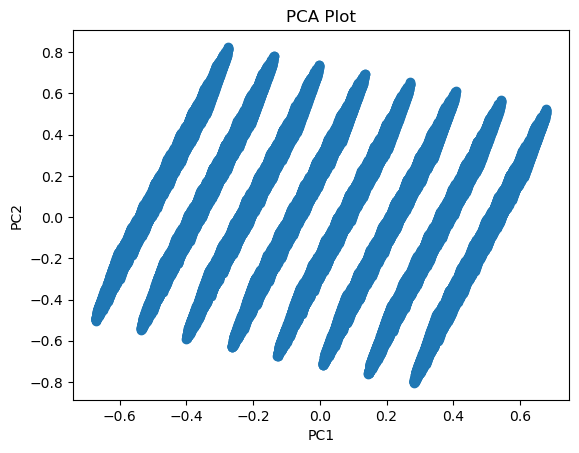

In [9]:
X = get_input_features(df, 0)
X_pca = perform_pca(X, 2)
plot_2D_pca(X_pca, 0, 1)

In [10]:
# birch_point_count_for_cluster, birch_labels = birch_clustering(X, 8, threshold=0.1)
# birch_clusters = birch_point_count_for_cluster.keys()
# birch_num_samples = min(min(birch_point_count_for_cluster.values()), 2000)

# plot_clusters(X_pca, birch_labels, birch_clusters)
# birch_samples = get_samples_from_clusters(birch_num_samples, birch_clusters, X, birch_labels)
# birch_candidates = find_candidates(birch_clusters, birch_samples)
# print(f"Num of candidates found: {len(birch_candidates)}")

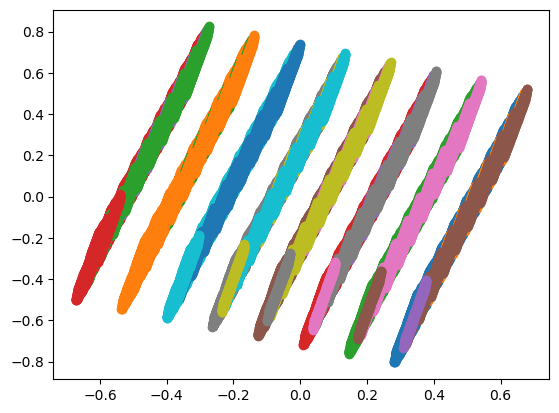

Num of candidates found: 30


In [11]:
dbscan_point_counts, dbscan_labels = dbscan_clustering(X, 0.142, 10)
dbscan_clusters = dbscan_point_counts.keys()
dbscan_num_samples =  min(min(dbscan_point_counts.values()), 2000)

plot_clusters(X_pca, dbscan_labels, dbscan_clusters)
dbscan_samples = get_samples_from_clusters(dbscan_num_samples, dbscan_clusters, X, dbscan_labels)
dbscan_candidates = find_candidates(dbscan_clusters, dbscan_samples)
print(f"Num of candidates found: {len(dbscan_candidates)}")

In [12]:
def verify_candidates(candidates_by_cluster, cluster_ranges, dnn_model):
  dp = MarabouCoreDP(lower_bound=-10, upper_bound=10)
  examined_candidates = set()
  accepted_candidates = []
  
  print("Verifying cluster candidates...")
  for cluster, candidate in candidates_by_cluster.items(): 
    print(f"Verifying candidate of cluster {cluster}")
    if json.dumps(candidate) in examined_candidates: 
      continue
      
    ranges = cluster_ranges[cluster]
    status, _, __, ___ = dp.solve(candidate, dnn_model, ranges, specification_for_classes[0])
    examined_candidates.add(json.dumps(candidate))
    
    if status == "unsat": 
      accepted_candidates.append((cluster, candidate))

  print(f"Accepted {len(accepted_candidates)} decision patterns.")
  return accepted_candidates

In [13]:
dnn_model = Acasxu1_1()
dnn_model.load_state_dict(torch.load('../models/acasxu_1_1.pt'))
dbscan_cluster_ranges = get_cluster_ranges(dbscan_clusters, X, dbscan_labels)

In [14]:
# accepted_candidates = verify_candidates(dbscan_candidates, dbscan_cluster_ranges, dnn_model)

In [15]:
# cluster, input_property = accepted_candidates[0]
# attr_min, attr_max = get_cluster_min_max_features(cluster, X, dbscan_labels)

In [16]:
# box = UnderApproximationBox()
# problem, result = box.solve(input_property, attr_min, attr_max, dnn_model)

In [17]:
test_candidate = copy.deepcopy(dbscan_candidates[0])
import random
test_candidate2 = {
#   'relu0': [val for val in test_candidate['relu0']],
#   'relu1': [val for val in test_candidate['relu1']],
#   'relu2': [val for val in test_candidate['relu2']],
#   'relu3': [val for val in test_candidate['relu3']],
#   'relu4': [val for val in test_candidate['relu4']],
#   'relu5': [val for val in test_candidate['relu5']],
  
  'relu0': [random.choice(['--', '--', 'ON', "OFF"]) for i in range(50)],
  'relu1': [random.choice(['--', '--', 'ON', "OFF"]) for i in range(50)],
  'relu2': [random.choice(['--', '--', 'ON', "OFF"]) for i in range(50)],
  'relu3': [random.choice(['--', '--', 'ON', "OFF"]) for i in range(50)],
  'relu4': [random.choice(['--', '--', 'ON', "OFF"]) for i in range(50)],
  'relu5': [random.choice(['--', '--', 'ON', "OFF"]) for i in range(50)],
}
print(test_candidate)
print(test_candidate2)

{'relu0': ['--', '--', '--', '--', '--', '--', '--', 'OFF', '--', '--', '--', '--', '--', '--', 'ON', '--', '--', 'ON', 'ON', '--', 'OFF', 'ON', '--', '--', 'OFF', 'OFF', '--', 'ON', '--', 'ON', 'ON', 'ON', 'OFF', '--', 'ON', 'ON', '--', 'ON', 'OFF', 'ON', '--', 'ON', 'ON', '--', '--', 'OFF', '--', 'ON', 'OFF', '--'], 'relu1': ['OFF', 'OFF', 'OFF', 'OFF', 'OFF', 'OFF', '--', '--', '--', '--', 'OFF', '--', 'OFF', '--', '--', '--', 'OFF', '--', 'OFF', '--', '--', '--', '--', 'OFF', 'OFF', 'OFF', 'OFF', 'OFF', 'OFF', 'ON', '--', 'OFF', '--', 'OFF', 'ON', 'OFF', 'OFF', 'OFF', 'OFF', 'OFF', 'OFF', 'OFF', 'OFF', 'OFF', '--', '--', 'OFF', 'OFF', '--', '--'], 'relu2': ['--', 'OFF', '--', 'ON', '--', '--', '--', '--', '--', 'OFF', '--', '--', '--', '--', 'OFF', '--', '--', 'ON', 'OFF', 'OFF', '--', '--', 'ON', '--', '--', '--', '--', '--', 'OFF', '--', '--', '--', 'OFF', 'OFF', '--', '--', '--', '--', '--', 'OFF', '--', 'ON', '--', 'OFF', '--', '--', '--', 'OFF', '--', '--'], 'relu3': ['OFF', '

In [18]:
input_ranges = dbscan_cluster_ranges[0]
print(input_ranges)
dp = MarabouCoreDP(lower_bound=-100, upper_bound=100)

[[-0.240207, 0.352183], [-0.5, 0.5], [-0.5, 0.5], [-0.5, -0.5], [-0.5, 0.5]]


In [ ]:
res = dp.solve(test_candidate, dnn_model, input_ranges, specification_for_classes[0])
res

In [20]:
# {'relu0': ['--', 'OFF', '--', 'ON', 'ON', '--', 'OFF', '--', 'OFF', 'ON', 'ON', 'OFF', '--', 'OFF', 'ON', 'ON', 'ON', 'OFF', 'ON', 'OFF', 'OFF', 'ON', '--', '--', '--', '--', 'OFF', '--', '--', 'ON', '--', 'ON', 'ON', 'ON', '--', 'ON', 'ON', 'OFF', 'ON', '--', 'OFF', '--', '--', '--', 'OFF', 'OFF', '--', 'ON', 'OFF', '--'], 'relu1': ['OFF', 'OFF', 'ON', 'ON', '--', '--', '--', '--', '--', 'OFF', '--', '--', 'OFF', 'OFF', '--', 'OFF', '--', '--', '--', '--', '--', '--', '--', '--', 'OFF', 'OFF', 'OFF', 'ON', 'ON', '--', 'OFF', '--', '--', 'OFF', 'ON', 'OFF', '--', 'OFF', 'OFF', '--', 'OFF', 'OFF', '--', 'ON', '--', '--', '--', 'ON', 'ON', '--'], 'relu2': ['OFF', '--', 'OFF', '--', 'OFF', '--', '--', '--', '--', '--', '--', 'ON', 'ON', 'OFF', '--', '--', 'OFF', 'ON', 'ON', 'ON', 'ON', 'ON', '--', 'OFF', 'OFF', '--', 'ON', 'ON', '--', 'OFF', '--', 'OFF', 'ON', '--', '--', '--', '--', '--', '--', '--', '--', '--', 'OFF', '--', 'ON', '--', 'ON', 'ON', '--', '--'], 'relu3': ['--', 'OFF', 'ON', 'OFF', '--', '--', '--', '--', 'ON', '--', '--', 'ON', 'ON', 'ON', 'ON', '--', '--', '--', '--', '--', '--', '--', '--', '--', '--', '--', '--', 'OFF', '--', '--', '--', 'ON', '--', '--', 'OFF', '--', '--', 'OFF', '--', '--', 'ON', '--', 'ON', 'ON', '--', '--', 'OFF', 'OFF', '--', 'ON'], 'relu4': ['OFF', 'ON', '--', 'ON', 'ON', '--', 'ON', '--', 'OFF', '--', '--', '--', '--', '--', 'ON', '--', '--', 'OFF', '--', 'OFF', 'OFF', 'ON', '--', '--', '--', 'ON', 'ON', '--', '--', '--', '--', 'ON', 'OFF', 'OFF', '--', 'OFF', 'ON', '--', 'ON', 'ON', 'OFF', '--', '--', 'ON', '--', 'OFF', 'OFF', '--', '--', 'OFF'], 'relu5': ['OFF', '--', '--', '--', '--', '--', '--', 'ON', '--', 'OFF', '--', 'ON', '--', 'ON', '--', '--', 'ON', 'ON', 'OFF', 'ON', 'ON', '--', '--', '--', 'ON', 'OFF', 'ON', '--', 'ON', '--', 'OFF', '--', '--', '--', '--', 'ON', '--', '--', 'OFF', 'ON', '--', '--', 'OFF', '--', 'ON', 'ON', '--', '--', '--', '--']}

In [21]:
# res = dp.solve(a, dnn_model, input_ranges, specification_for_classes[0])
# res